# Classes Level 2: Cumulative Sums
This notebook will refine the class structure from level 1 (itself refined from level 0) to analyze temperature differences between the lcds and the aws sensors. It will cumuluate these differences to understand the trajectory of the error term through time.

Step 1 import the data file, initiate base class, and set up data file for instantiating class objects.

Step 2 create class to do analysis and class to remove bad data values (see ref_data_test.ipynb for i.d. and fix of bad values)

Step 3 Look at cumulative differences to understand the trajectory over the measurement season

Step 4 Look at mean temp difference per hour of the day to understand its daily evolution

Step 5 Look at suspected cause (radiation) and its evolution through the day.

Step 6 Sunshine values from Zollikofen

## Step 1
Import the data file, initiate base class, and set up data file for instantiating class objects.

In [1]:
# Import statements
import pandas as pd
import os
import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoLocator
from itertools import product
import numpy as np
# Directories for reading and writing data
thedir = os.getcwd()
writedir = os.path.abspath(os.path.join(os.path.dirname(thedir), '..', 'data/interim'))
extdir = os.path.abspath(os.path.join(os.path.dirname(thedir), '..', 'data/external'))
figdir = os.path.abspath(os.path.join(os.path.dirname(thedir), '..', 'figures'))

# load data (reference data set of lcd and aws stations from 2018)
data_test = pd.read_csv(F'{extdir}/ref_2018.csv')

In [2]:
# base sensor class inherited by the different sensor type subclasses
class Sensors:
    def __init__(self, name=None, station = None, qty=None, sensor_type=None, data = None):
        self.name = name
        self.station = station
        self.qty = qty
        self.sensor_type = sensor_type
        self.data = data
    def placeholder():
        pass
# create a sensor object for each colum
data_test['md'] = pd.to_datetime(data_test['Date_time_CET'], infer_datetime_format=True)
data_test_ = data_test.loc[:,'BOLL_LCD_TEMP':]
log_cols = [x for x in data_test_.columns if '_' in x]

mylist = []
for i in log_cols:
    data = data_test_[['md',i]].copy()
    data_ = data.set_index('md',inplace=True)
    if 'TEMP' in i:
        qty = 'temp'
    elif 'WIND' in i:
        qty = 'wind'
    elif 'RADI' in i:
        qty = 'radi'
    elif 'PREC' in i:
        qty = 'rain'
    elif 'SUN' in i:
        qty = 'sun'
    if 'LCD' in i:
        sensor_type = 'lcd'
    else:
        sensor_type = 'aws'
    if 'BOLL' in i:
        station = 'boll'
    if 'ZOLL' in i:
        station = 'zoll'
    if 'AFU' in i:
        station = 'afu'
    mylist.append(Sensors(i,station,qty,sensor_type,data))
aws_sensors = mylist

## Step 2 
Create class to remove bad data values (see ref_data_test.ipynb for i.d. and fix of bad values)

In [3]:
# class to remove bad data values
class Wrangler:
    def __init__(self, sensors=None):
        self.sensors = sensors
    
    def mean_fix(self,sensor):
        data = sensor.data
        name = sensor.name
        data.reset_index(inplace=True,drop = False)
        wrong = data[data[name] < -1000]
        for i in wrong.index:
            if i > 5:
                il = range(i-5,i)
                ih = range(i+1,i+6)
                ind = [x for y in [il,ih] for x in y]
                for i in ind:
                    if i in wrong.index:
                        ind.remove(i)
                data_ = data.loc[ind]
                newmean = data_[name].mean()
                data.loc[data[name] == -9999, name] = newmean
        data.set_index('md',inplace=True)
        return data
a = [x for x in aws_sensors]
nw = Wrangler(a)
b = [nw.mean_fix(i) for i in a]

## Step 3 
Create and initialize main analysis class for this workbook.

In [4]:
class Crangler:
    def __init__(self, sensors=None):
        self.sensors = sensors
    def attack_sensors():
        pass
    def get_sensors(self,dict_,if_all):
        """
        Returns a list of sensors of the requested type according to passed dict values (sensor_type, qty, station)
        """
        newlist = [x for x in self.sensors]
        if if_all:
            return newlist
        else:
            for key,values in dict_.items(): 
                if key == 'sensor_type':
                    newlist = [x for x in newlist if x.sensor_type in values]
                if key == 'qty':
                    newlist = [x for x in newlist if x.qty in values]
                if key == 'station':
                    newlist = [x for x in newlist if x.station in values]
            return newlist
    
    def return_diff(self,cumpairs,sensors):
        newdict = {}
        for k,v in cumpairs.items():
            if len(v) > 1:
                newentries = {}
                for i in v:
                    aws = [x for x in sensors if x.name == i[0]]
                    lcd = [x for x in sensors if x.name == i[1]]
                    aws_data = aws[0].data
                    lcd_data = lcd[0].data
                    name_aws = aws[0].name
                    name_lsd = lcd[0].name
                    diff = lcd_data.subtract(aws_data[name_aws],axis = 0)
                    final_name = F"{name_lsd}-{name_aws}-{k}"
                    diff.columns = ["diff"]
                    diff["cum"] = diff["diff"].cumsum()
                    newentries[final_name] = diff
                newdict.update(newentries)
                    
            else:
                for i in v:
                    aws = [x for x in sensors if x.name == i[0]]
                    lcd = [x for x in sensors if x.name == i[1]]
                    aws_data = aws[0].data
                    lcd_data = lcd[0].data
                    name_aws = aws[0].name
                    name_lsd = lcd[0].name
                    diff = lcd_data.subtract(aws_data[name_aws],axis = 0)
                    final_name = F"{name_lsd}-{name_aws}-{k}"
                    diff.columns = ["diff"]
                    diff["cum"] = diff["diff"].cumsum()
                    newdict[final_name] = diff
        return newdict
    
    def get_pairs(self,sensors):
        stations = set([x.station for x in sensors])
        newdict = {}
        for i in stations:
            aws = set([x.name for x in sensors if (x.sensor_type == "aws") & (x.station == i)])
            lcd = set([x.name for x in sensors if (x.sensor_type == "lcd") & (x.station == i)])
            cross = list(product(aws, lcd))
            newdict[i] = cross
        return newdict
    
    def return_cumdiff(self,sensors):
        cumpairs = self.get_pairs(sensors) # to become something that checks the sensors
        data = self.return_diff(cumpairs,sensors)
        return data
    
    def make_frame(self,sensors):
        data = self.return_cumdiff(sensors)
        auto = pd.concat(data,axis = 1)
        return auto
    def get_hourly_cum_diff(self,sensors,value_wanted,stat_wanted,period,check_months):
        data = self.make_frame(sensors)
        data.columns = data.columns.map(''.join)
        cols = [x for x in data.columns if (value_wanted in x)]
        loggers = len(cols)
        data_ = data[cols].copy()
        data_.reset_index(inplace=True,drop=False)
        if period == 'h':
            data_[period] = data_.md.dt.strftime('%H')
        else:
            data_[period] = data_.md.dt.to_period(period)
        
        stats = [stat_wanted]*loggers
        wanted = dict(zip(cols,stats))
        
        if check_months:
            data_['m'] = data_.md.dt.strftime('%m')
            data_g = data_.groupby(['m',period]).agg(wanted)
            data_g.reset_index(inplace=True,drop = False)
            data_m =  data_g.melt(id_vars=[period,'m'], value_vars=cols,var_name = "aws-lcd station pair",value_name=value_wanted)
            return data_m
        else:
            data_g = data_.groupby([period]).agg(wanted)
            data_g.reset_index(inplace=True,drop = False)
            data_m =  data_g.melt(id_vars=[period], value_vars=cols,var_name = "aws-lcd station pair",value_name=value_wanted)
            return data_m
crangle = Crangler(aws_sensors)      

## Step 4 
Look at cumulative differences in lcd and aws sensors at each station to understand the trajectory over the measurement season

In [5]:
#sensor_dict = {'qty' : ['temp'],'station':['afu','boll']}
sensor_dict = {'qty' : ['temp']}
sensors = crangle.get_sensors(sensor_dict,False)
value_wanted = 'cum'
stat_wanted = 'mean'
period = 'd'
check_month = False
data_ = crangle.get_hourly_cum_diff(sensors,value_wanted,stat_wanted,period,check_month)

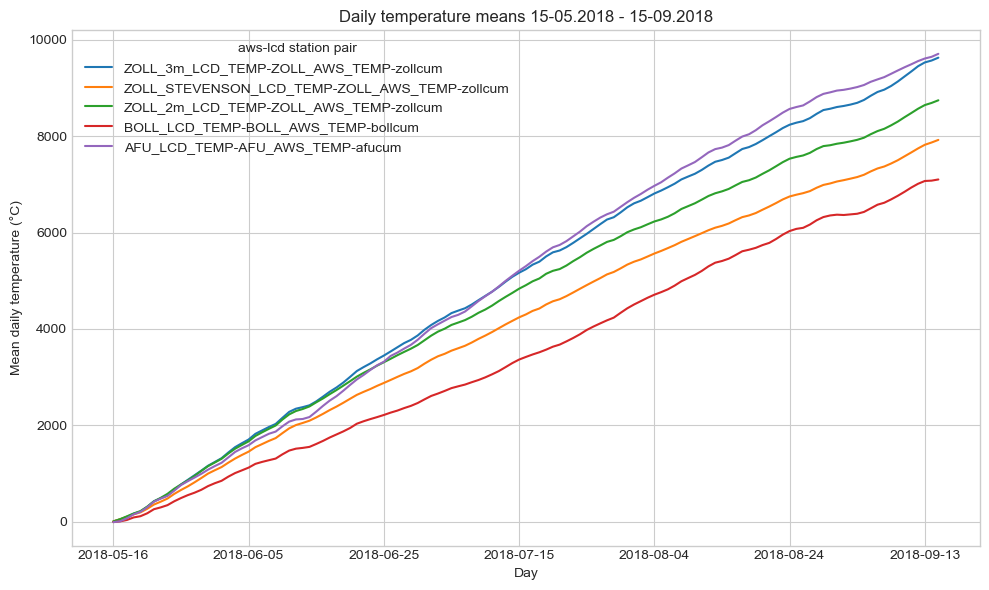

In [6]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

fig,axs = plt.subplots(figsize= (10,6))
sns.lineplot(data = data_,x=data_.d.astype(str),y=value_wanted,hue = 'aws-lcd station pair')
plt.xlabel("Day")
plt.ylabel("Mean daily temperature (°C)")
plt.title("Daily temperature means 15-05.2018 - 15-09.2018")
plt.tight_layout()
loc = AutoLocator()
axs.xaxis.set_major_locator(loc)
plt.savefig(F'{figdir}/cum-temp-diffs-by-station-2018.png')
plt.show()

In [7]:
sensor_dict = {'qty' : ['temp']}
sensors = crangle.get_sensors(sensor_dict,False)
value_wanted = 'dif'
stat_wanted = 'min'
period = 'h'
check_month = False
data_ = crangle.get_hourly_cum_diff(sensors,value_wanted,stat_wanted,period,check_month)

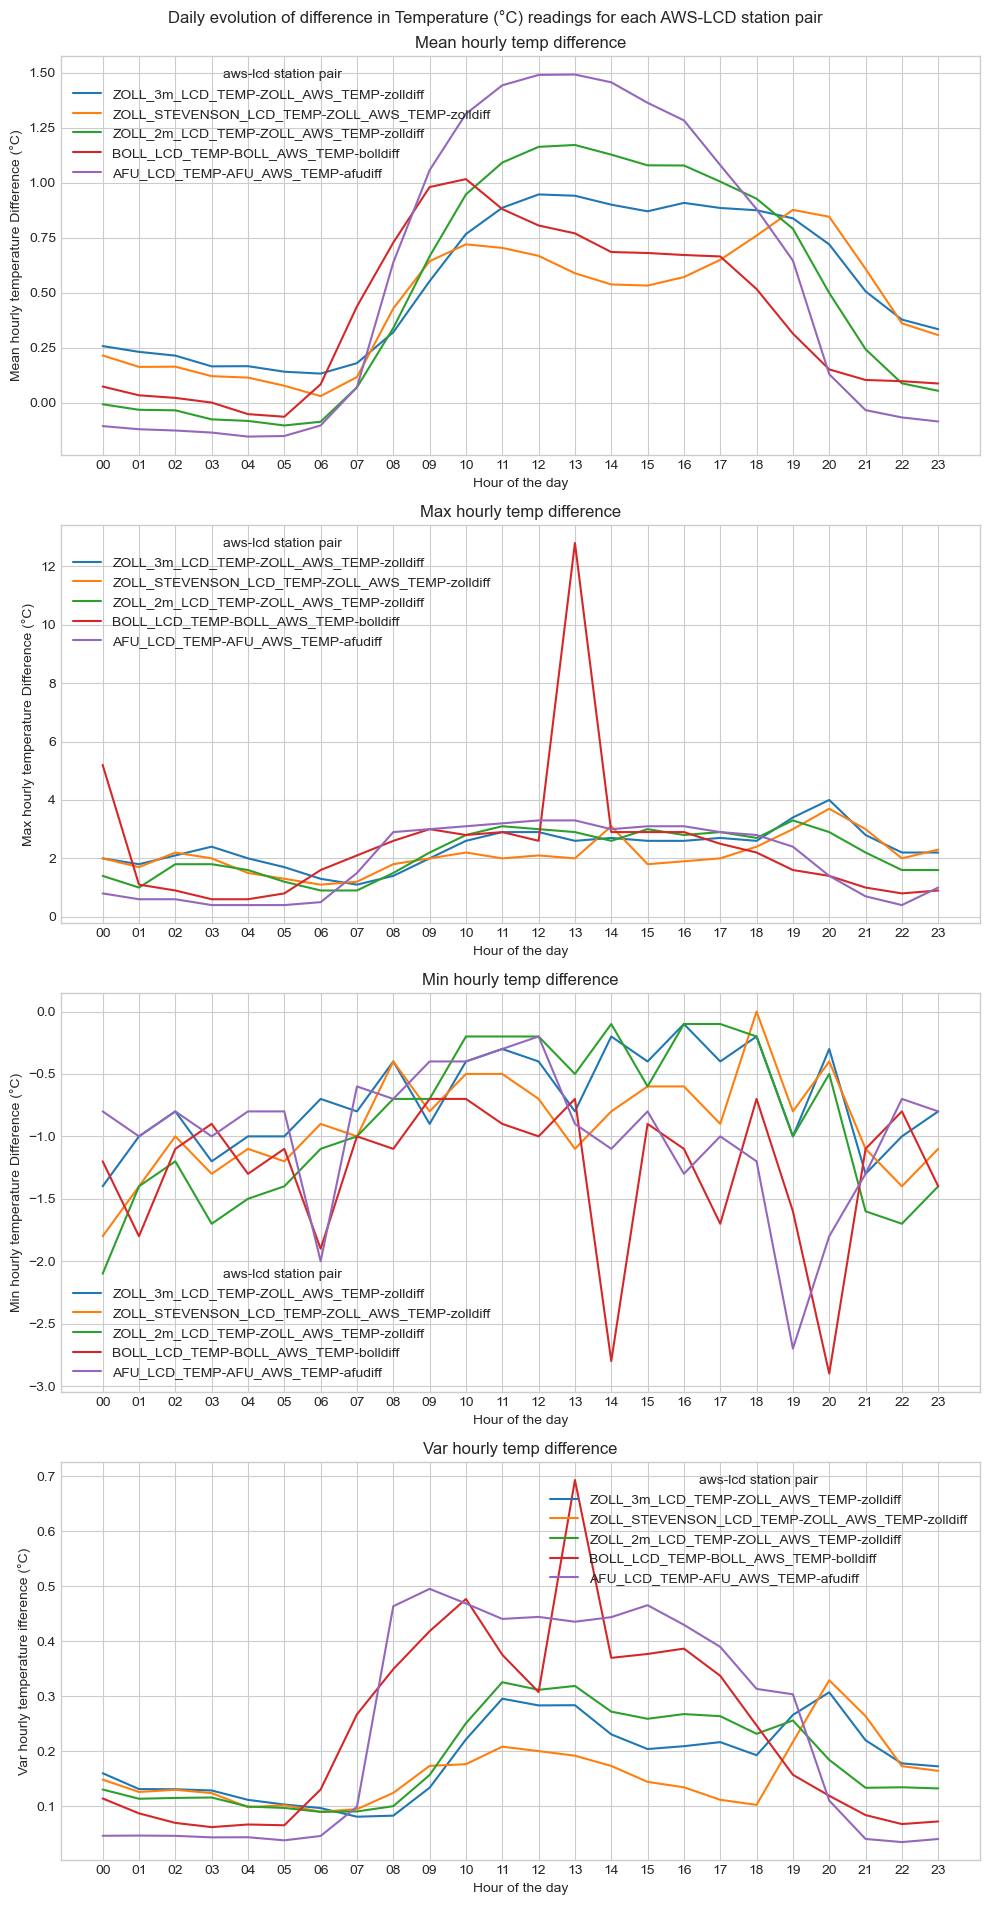

In [8]:
sensor_dict = {'qty' : ['temp']}
sensors = crangle.get_sensors(sensor_dict,False)
value_wanted = 'dif'
stat_wanted = 'mean'
period = 'h'

plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

fig,axs = plt.subplots(4,1,figsize = (10,20))
data_ = crangle.get_hourly_cum_diff(sensors,value_wanted,stat_wanted,period,check_month)
sns.lineplot(data = data_,x=data_.h,y=value_wanted,hue = 'aws-lcd station pair',ax = axs[0])
axs[0].set_xlabel("Hour of the day")
axs[0].set_ylabel("Mean hourly temperature Difference (°C)")
axs[0].set_title("Mean hourly temp difference")

stat_wanted = 'max'
data_ = crangle.get_hourly_cum_diff(sensors,value_wanted,stat_wanted,period,check_month)
sns.lineplot(data = data_,x=data_.h,y=value_wanted,hue = 'aws-lcd station pair',ax = axs[1])
axs[1].set_xlabel("Hour of the day")
axs[1].set_ylabel("Max hourly temperature Difference (°C)")
axs[1].set_title("Max hourly temp difference")

stat_wanted = 'min'
data_ = crangle.get_hourly_cum_diff(sensors,value_wanted,stat_wanted,period,check_month)
sns.lineplot(data = data_,x=data_.h,y=value_wanted,hue = 'aws-lcd station pair',ax = axs[2])
axs[2].set_xlabel("Hour of the day")
axs[2].set_ylabel("Min hourly temperature Difference (°C)")
axs[2].set_title("Min hourly temp difference")

stat_wanted = 'var'
data_ = crangle.get_hourly_cum_diff(sensors,value_wanted,stat_wanted,period,check_month)
sns.lineplot(data = data_,x=data_.h,y=value_wanted,hue = 'aws-lcd station pair',ax = axs[3])
axs[3].set_xlabel("Hour of the day")
axs[3].set_ylabel("Var hourly temperature ifference (°C)")
axs[3].set_title("Var hourly temp difference")

plt.suptitle('Daily evolution of difference in Temperature (°C) readings for each AWS-LCD station pair')
plt.tight_layout(rect=[0, 0.03, 1, 0.99])
#plt.savefig(F'{figdir}/hourly_cum_differences_months-2018.png')
plt.show()

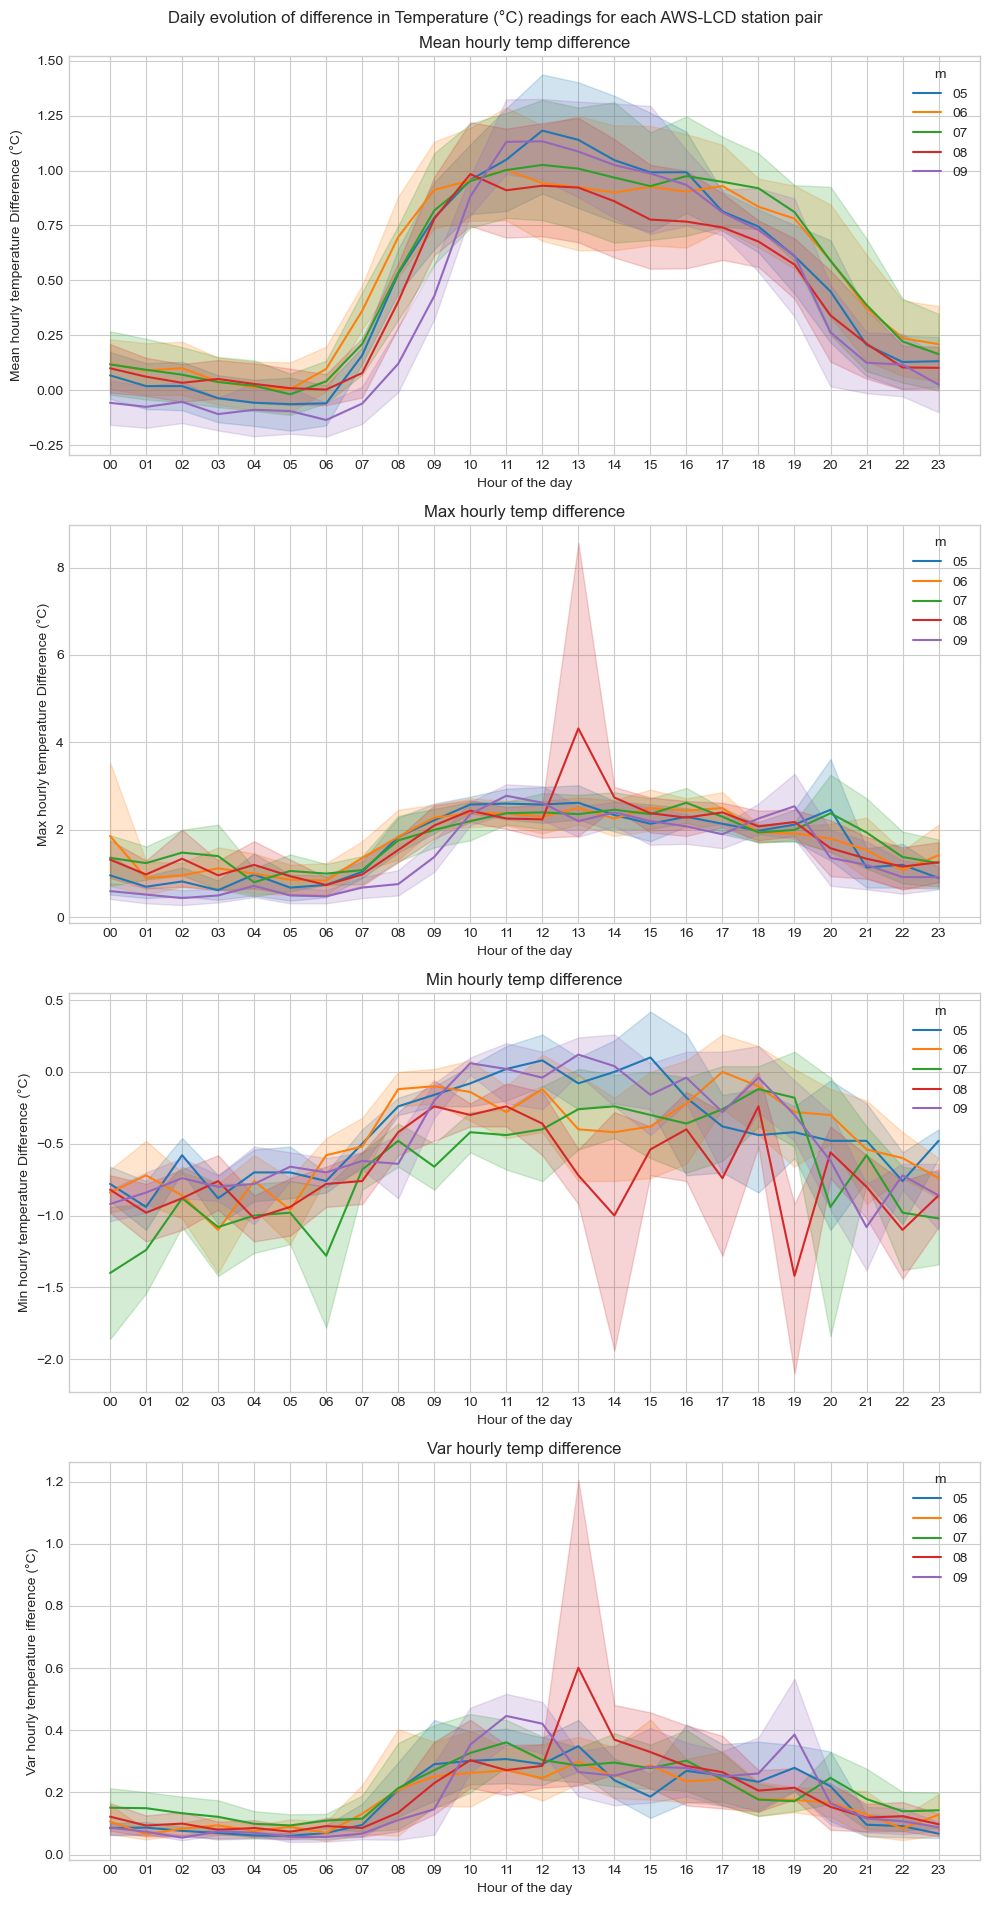

In [9]:
sensor_dict = {'qty' : ['temp']}
sensors = crangle.get_sensors(sensor_dict,False)
value_wanted = 'dif'
stat_wanted = 'mean'
period = 'h'
check_month = True
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

fig,axs = plt.subplots(4,1,figsize = (10,20))
data_ = crangle.get_hourly_cum_diff(sensors,value_wanted,stat_wanted,period,check_month)
sns.lineplot(data = data_,x=data_.h,y=value_wanted,hue = 'm',ax = axs[0])
axs[0].set_xlabel("Hour of the day")
axs[0].set_ylabel("Mean hourly temperature Difference (°C)")
axs[0].set_title("Mean hourly temp difference")

stat_wanted = 'max'
data_ = crangle.get_hourly_cum_diff(sensors,value_wanted,stat_wanted,period,check_month)
sns.lineplot(data = data_,x=data_.h,y=value_wanted,hue = 'm',ax = axs[1])
axs[1].set_xlabel("Hour of the day")
axs[1].set_ylabel("Max hourly temperature Difference (°C)")
axs[1].set_title("Max hourly temp difference")

stat_wanted = 'min'
data_ = crangle.get_hourly_cum_diff(sensors,value_wanted,stat_wanted,period,check_month)
sns.lineplot(data = data_,x=data_.h,y=value_wanted,hue = 'm',ax = axs[2])
axs[2].set_xlabel("Hour of the day")
axs[2].set_ylabel("Min hourly temperature Difference (°C)")
axs[2].set_title("Min hourly temp difference")

stat_wanted = 'var'
data_ = crangle.get_hourly_cum_diff(sensors,value_wanted,stat_wanted,period,check_month)
sns.lineplot(data = data_,x=data_.h,y=value_wanted,hue = 'm',ax = axs[3])
axs[3].set_xlabel("Hour of the day")
axs[3].set_ylabel("Var hourly temperature ifference (°C)")
axs[3].set_title("Var hourly temp difference")

plt.suptitle('Daily evolution of difference in Temperature (°C) readings for each AWS-LCD station pair')
plt.tight_layout(rect=[0, 0.03, 1, 0.99])
#plt.savefig(F'{figdir}/hourly_cum_differences_months-2018.png')
plt.show()

In [10]:
sensor_dict = {'qty' : ['temp']}
sensors = crangle.get_sensors(sensor_dict,False)
value_wanted = 'dif'
stat_wanted = 'mean'
period = 'd'
check_month = False
data_ = crangle.get_hourly_cum_diff(sensors,value_wanted,stat_wanted,period,check_month)

In [11]:
data = pd.DataFrame

In [12]:
data

pandas.core.frame.DataFrame

In [13]:
sensor_dict = {'qty' : ['rain','wind']}
sensors = crangle.get_sensors(sensor_dict,False)
newlist = []
for j in ['wind']:
    for i in ['zoll','boll','afu']:
        data = pd.DataFrame()
        b = [x.data for x in sensors if (x.station== i) & (x.qty == j)]
        max_ = ['max']
        min_ = ['min']
        mean_ = ['mean']
        data = b[0].copy()
        name = data.columns[0]
        data.reset_index(inplace=True,drop= False)
        data[period] = data.md.dt.to_period(period)
        data[i] = i
        newlist.append(data.groupby([period]).agg({name:max_}))
        newlist.append(data.groupby([period]).agg({name:min_}))
        newlist.append(data.groupby([period]).agg({name:mean_}))

for j in ['rain']:
    for i in ['zoll','boll']:
        data = pd.DataFrame()
        b = [x.data for x in sensors if (x.station== i) & (x.qty == j)]
        max_ = ['max']
        min_ = ['min']
        mean_ = ['mean']
        data = b[0].copy()
        name = data.columns[0]
        data.reset_index(inplace=True,drop= False)
        data[period] = data.md.dt.to_period(period)
        data[i] = i
        newlist.append(data.groupby([period]).agg({name:max_}))
        newlist.append(data.groupby([period]).agg({name:min_}))
        newlist.append(data.groupby([period]).agg({name:mean_}))

In [14]:
df = pd.concat(newlist,axis=1)

In [15]:
df.columns = [' '.join(col) for col in df.columns.values]

In [16]:
df.columns = [F'{x[:9]}-{x[-4:]}' for x in df.columns]
df.reset_index(inplace=True, drop = False)

In [17]:
df.columns

Index(['d', 'ZOLL_WIND- max', 'ZOLL_WIND- min', 'ZOLL_WIND-mean',
       'BOLL_WIND- max', 'BOLL_WIND- min', 'BOLL_WIND-mean', 'AFU_WIND_- max',
       'AFU_WIND_- min', 'AFU_WIND_-mean', 'ZOLL_PREC- max', 'ZOLL_PREC- min',
       'ZOLL_PREC-mean', 'BOLL_PREC- max', 'BOLL_PREC- min', 'BOLL_PREC-mean'],
      dtype='object')

In [18]:
melted = df.melt(['d'],value_name = "statistic",var_name="station")

In [19]:
melted

,d,station,statistic
0,2018-05-16,ZOLL_WIND- max,3.000000
1,2018-05-17,ZOLL_WIND- max,5.700000
2,2018-05-18,ZOLL_WIND- max,5.100000
3,2018-05-19,ZOLL_WIND- max,5.900000
4,2018-05-20,ZOLL_WIND- max,5.000000
...,...,...,...
1840,2018-09-11,BOLL_PREC-mean,0.000000
1841,2018-09-12,BOLL_PREC-mean,0.006250
1842,2018-09-13,BOLL_PREC-mean,0.047222
1843,2018-09-14,BOLL_PREC-mean,0.025694


In [20]:
def text_change_stat(x):
    return x[-4:]
def text_change_qty(x):
    return x[4:9]
def text_change_stati(x):
    return x[:3]

melted['stat'] = melted.station.apply(lambda x: text_change_stat(x))
melted['qty'] = melted.station.apply(lambda x: text_change_qty(x))
melted['stati'] = melted.station.apply(lambda x: text_change_stati(x))
melted['day'] = melted.d.astype('string')

In [21]:
melted_ = melted[['statistic','stati','qty','stat','day']]

In [22]:
melted.qty.unique()

array(['_WIND', 'WIND_', '_PREC'], dtype=object)

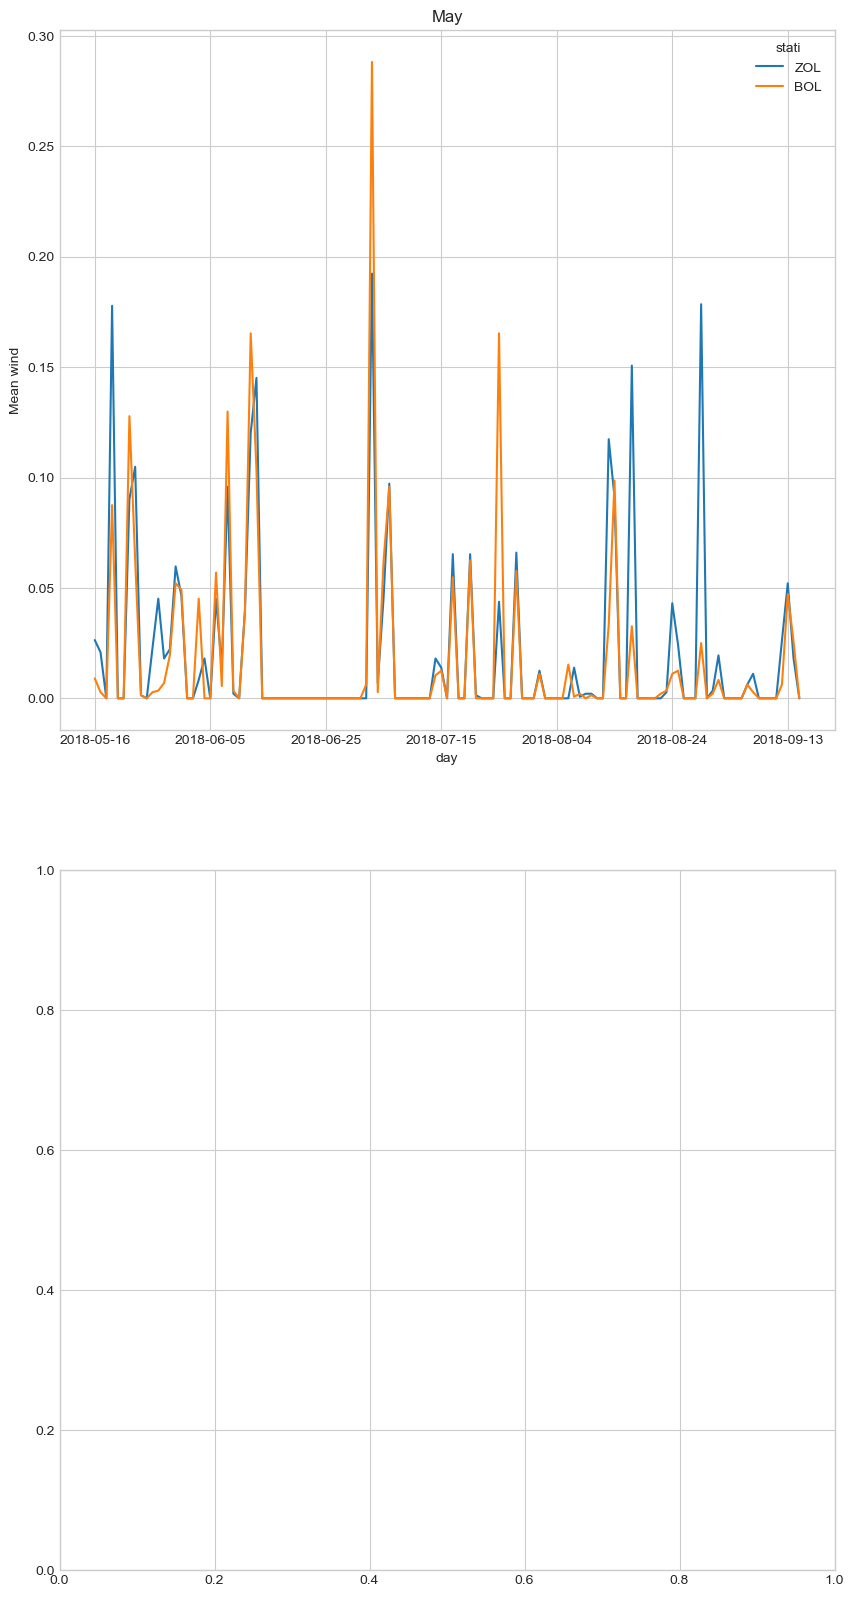

In [23]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')
fig,axs = plt.subplots(2,1,figsize = (10,20))
data_ = melted_.loc[(melted_.stat == 'mean')& (melted_.qty=="_PREC")]
sns.lineplot(data = data_,x=data_.day,y='statistic',hue = 'stati',ax = axs[0])
axs[0].set_xlabel("day")
axs[0].set_ylabel("Mean wind")
axs[0].set_title("May")
loc = AutoLocator()
axs[0].xaxis.set_major_locator(loc)

AttributeError: 'DataFrame' object has no attribute 'hour'

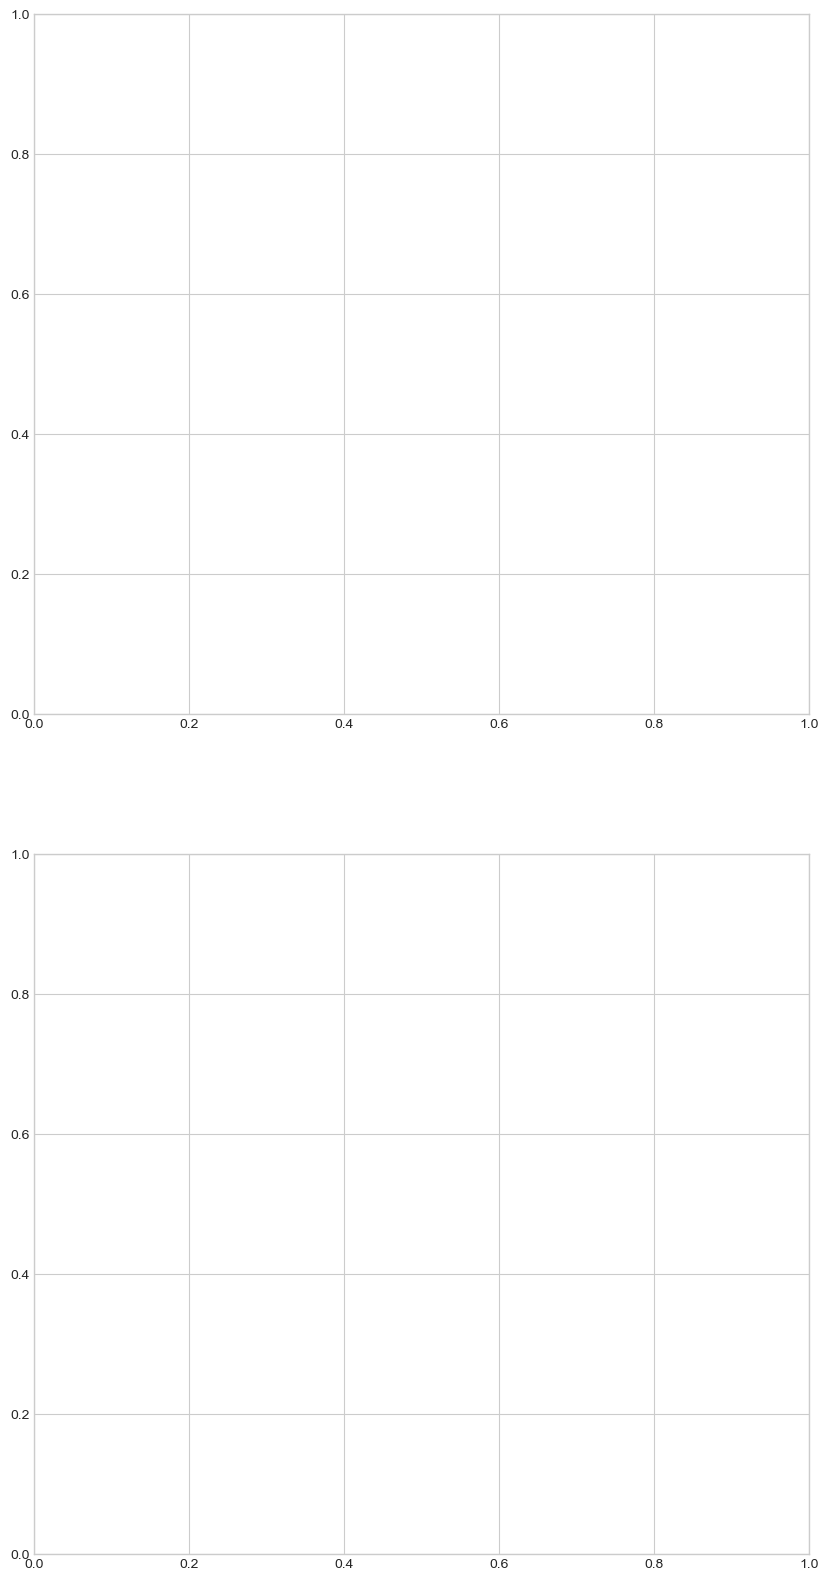

In [24]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')
fig,axs = plt.subplots(2,1,figsize = (10,20))
data_ = melted_[melted_.stat == 'mean']
sns.lineplot(data = data_,x=data_.hour,y='statistic',hue = 'stati',ax = axs[0])
axs[0].set_xlabel("Hour of the day")
axs[0].set_ylabel("Mean hourly temperature Difference (°C)")
axs[0].set_title("May")
loc = AutoLocator()
axs[0].xaxis.set_major_locator(loc)

data = melted_[melted_.stat == 'max']
sns.lineplot(data = data,x=data.hour,y='statistic',hue = 'stati',ax = axs[1])
axs[1].set_xlabel("Hour of the day")
axs[1].set_ylabel("Mean hourly temperature Difference (°C)")
axs[1].set_title("June")
loc = AutoLocator()
axs[1].xaxis.set_major_locator(loc)

data = melted_[melted_.stat == 'min']
sns.lineplot(data = data,x=data.hour,y='statistic',hue = 'stati',ax = axs[2])
axs[2].set_xlabel("Hour of the day")
axs[2].set_ylabel("Mean hourly temperature Difference (°C)")
axs[2].set_title("July")
loc = AutoLocator()
axs[2].xaxis.set_major_locator(loc)

plt.suptitle('Mean difference in temperature (°C) readings for each AWS-LCD station pair')
plt.tight_layout(rect=[0, 0.03, 1, 0.99])
#plt.savefig(F'{figdir}/hourly_cum_differences_months-2018.png')
plt.show()

## Step 4 
Look at mean temp difference per hour of the day to understand its daily evolution

In [ ]:
sensor_dict = {'qty' : ['temp']}
sensors = crangle.get_sensors(sensor_dict,False)
value_wanted = 'dif'
stat_wanted = 'mean'
period = 'h'
check_month = True
data_ = crangle.get_hourly_cum_diff(sensors,value_wanted,stat_wanted,period,check_month)

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')
fig,axs = plt.subplots(5,1,figsize = (10,20))
data_monthly = data_[data_.m == '05']
sns.lineplot(data = data_monthly,x=data_.h,y=value_wanted,hue = 'aws-lcd station pair',ax = axs[0])
axs[0].set_xlabel("Hour of the day")
axs[0].set_ylabel("Mean hourly temperature Difference (°C)")
axs[0].set_title("May")

data_monthly = data_[data_.m == '06']
sns.lineplot(data = data_monthly,x=data_.h,y=value_wanted,hue = 'aws-lcd station pair',ax = axs[1])
axs[1].set_xlabel("Hour of the day")
axs[1].set_ylabel("Mean hourly temperature Difference (°C)")
axs[1].set_title("June")

data_monthly = data_[data_.m == '07']
sns.lineplot(data = data_monthly,x=data_.h,y=value_wanted,hue = 'aws-lcd station pair',ax = axs[2])
axs[2].set_xlabel("Hour of the day")
axs[2].set_ylabel("Mean hourly temperature Difference (°C)")
axs[2].set_title("July")

data_monthly = data_[data_.m == '08']
sns.lineplot(data = data_monthly,x=data_.h,y=value_wanted,hue = 'aws-lcd station pair',ax = axs[3])
axs[3].set_xlabel("Hour of the day")
axs[3].set_ylabel("Mean hourly temperature Difference (°C)")
axs[3].set_title("August")

data_monthly = data_[data_.m == '09']
sns.lineplot(data = data_monthly,x=data_.h,y=value_wanted,hue = 'aws-lcd station pair',ax = axs[4])
axs[4].set_xlabel("Hour of the day")
axs[4].set_ylabel("Mean hourly temperature Difference (°C)")
axs[4].set_title("September")

plt.suptitle('Mean difference in temperature (°C) readings for each AWS-LCD station pair')
plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.savefig(F'{figdir}/hourly_cum_differences_months-2018.png')
plt.show()

## Step 5 
Look at suspected cause (radiation) and its evolution through the day.

In [ ]:
sensor_dict = {'qty' : ['radi','sun']}
sensors_ = crangle.get_sensors(sensor_dict,False)
period = 'h'
monthly = True
wanted = "mean"
newlist = []
for i in sensors_:
    data = i.data
    qty = i.qty
    name = i.name
    station = i.station
    if (period == 'h') & (monthly):
        data[period] = data.index.strftime('%H')
        data['m'] = data.index.strftime('%m')
        data_g = data.groupby(['m',period]).agg(wanted)
        newlist.append(data_g)
        #data_g.reset_index(inplace=True,drop = False)
        #data_m = data_g.melt(id_vars=[period,'m'], value_vars=cols,var_name = "aws-lcd station pair",value_name=value_wanted)
        
newdf =pd.concat(newlist,axis=1)
cols = [ x for x in newdf.columns if "SUN" not in x]
newdf.reset_index(inplace=True,drop=False)
data_m =  newdf.melt(id_vars=[period,'m'], value_vars=cols,var_name = "sensor-name",value_name=wanted)

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

fig,axs = plt.subplots(1,2,figsize= (10,6))
sns.lineplot(data = data_m,x=period,y=wanted,hue = 'sensor-name',ax = axs[0])
axs[0].set_xlabel("Hour of the day")
axs[0].set_ylabel("Mean hourly temperature Difference (°C)")
axs[0].set_title("Sensor")

sns.lineplot(data = data_m,x=period,y=wanted,hue = 'm',ax = axs[1])
axs[1].set_xlabel("Hour of the day")
axs[1].set_ylabel("Net Radiation")
axs[1].set_title("Month")
plt.tight_layout()
plt.savefig(F'{figdir}/radiation-all_stations-months-2018.png')
plt.show()

## Step 6
Sushine (only from Zollikofen station)

In [ ]:
a = [x for x in sensors if x.qty == "sun"]
b = a[0]
data = b.data
data[period] = data.index.strftime('%H')
data['m'] = data.index.strftime('%m')
data_g = data.groupby(['m',period]).agg(wanted)
newdf.reset_index(inplace=True,drop=False)
data_m =  newdf.melt(id_vars=[period,'m'], value_vars=b.name,var_name = "time",value_name='sunshine')

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

fig,ax = plt.subplots(figsize= (7,5))
sns.barplot(data = data_m,x=period,y='sunshine',hue = 'm')
plt.xlabel("Hour of the day")
plt.ylabel("Sunshine (scale tbd)")
plt.title("Mean Sunshine Zollikofen")
plt.tight_layout()
plt.savefig(F'{figdir}/sunshine-zollikofen-2018.png')
plt.show()